## Task 1: Predicting traffic flow using time series forecasting

**Initial note**: It may be beneficial to read through all the subparts to this taks before answering any of them.

Begin by downloading and reading about the dataset at https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume.

Run the cell below to load the data into a pandas dataframe.

In [34]:
import pandas as pd
import numpy as np
import time as t
X = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

The dataset corresponds to 48204 measurements $\{\mathbf{x}_1,\ldots,\mathbf{x}_{48204}\}$ with feature vectors $\mathbf{x}_i$ containing 9 different features. The time between each measurement is 1 hour, as can be observed from the column **date_time**. This is different from most datasets since there is also a temporal structure to be considered. Such datasets are called time series. The column **traffic_volume** (denoted $x_i^{(\text{flow})}$) corresponds to the traffic flow, which you will be forecasting. An important note is that this dataset only contains the traffic flow at one location. For many time series traffic flow datasets you may find information about the traffic flow at various different road segments. This can in general be useful since the traffic flow at one road segment might be correlated with the traffic flow at some other road segment some amount of time into the future, which enables more accurate forecasts.


In this assignment you will use the **moving window** method to perform forecasts. This method predicts the traffic flow $h$ time steps into the future based on the $n$ previous measurements

\begin{equation}
    \hat{x}_{t+h}^{(\text{flow})} = f\left(\boldsymbol{x}_{t-n+1}, \boldsymbol{x}_{t-n+2}, \ldots, \boldsymbol{x}_{t}\right), \forall t \in\{n, n+1, \ldots, T-h\}
\end{equation}

where $T$ is the number of measurements in the time series. The function $f$ represents some regression model (e.g. some machine learning model) that predicts the traffic flow $\hat{x}_{t+h}^{(\text{flow})}$.


#### a) Data preprocessing

We begin by splitting the time series into two parts. Setting "shuffle=False" is very important to maintain the temporal structure (i.e., the order of the rows can not change since that could lead to forecasting the past). **X_train** will be used for training (i.e., learning the temporal patterns) and **X_test** will be used for testing.

In [35]:
from sklearn.preprocessing import normalize


import pandas as pd
import numpy as np
X = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')


X.drop_duplicates(subset='date_time', keep=False, inplace=True)


# Dropping stuff for now
# I am choosing to drop Weather aspects of the data as I believe the bulk of the importance is in the precipitation data
X = X.drop('weather_main',axis=1) 
X = X.drop('weather_description',axis=1)
X = X.drop('clouds_all',axis=1)
#X = X.drop('temp',axis=1)
'''
Updating the datetime column to consist of only hours, this is more mangeable/understandable in a traffic flow sense
This gives repetitions to the data points whereas the given datetime would be entirely unique
You could take this a step further and find out the day of the week for each date, and we could then learn about
day to day patterns, e.g. rush hours during weekdays. I figured adding to the data set in this way was out of scope here.
'''
X['hour'] = pd.to_datetime(X.date_time).dt.hour
X = X.drop('date_time',axis=1)

# Normalizing the traffic volume data
traffic_vol = X.traffic_volume
traffic_vol = ( traffic_vol - traffic_vol.mean() ) / traffic_vol.std()
X.traffic_volume = traffic_vol

# Normalizing the rain
snow_1h = X.snow_1h
snow_1h = ( snow_1h - snow_1h.mean() ) / snow_1h.std()
X.snow_1h = snow_1h

# Normalizing the snow
rain_1h = X.rain_1h
rain_1h = ( rain_1h - rain_1h.mean() ) / rain_1h.std()
X.rain_1h = rain_1h

# Normalizing the temperature
temp = X.temp
temp = ( temp - temp.mean() ) / temp.std()
X.temp = temp

In [36]:
# Updating the holiday data such that 00:00 is not the only time considered a "holiday"
holiday = np.array(X.holiday)

holiday_start = np.argwhere(holiday!='None').flatten()

for idx in holiday_start: 
    holiday[idx:idx+23] = 1

holiday[np.argwhere(holiday=='None')] = 0


X.holiday = holiday

In [37]:
from sklearn.model_selection import train_test_split
X_train_processed, X_test_processed = train_test_split(X, test_size=0.2, shuffle=False)

Now, note that all the $9$ features may not be so helpful when forecasting the traffic flow $x_i^{(\text{flow})}$. Therefore, preprocess the data in some way that you feel is appropriate. This could include selecting which features to include, data normalization, preprocessing of categorical features or anything that you think could be useful. It might be useful to plot the data in different ways in order to detect any patterns. Features that are correlated with the traffic flow should be the most interesting.

#### b) Time series forecasting as Supervised Learning

At this point we have two sets of time series: training and test sets. But how do we learn the function $f$? One common approach is to turn it into a supervised learning problem. However, this requires inputs $\mathbf{x}_i$ with associated labels $\mathbf{y}_i$. The trick is to slide through the time series with a window size $n$ and associate each sequence $\boldsymbol{x}_{t-n+1}, \boldsymbol{x}_{t-n+2}, \ldots, \boldsymbol{x}_{t}$ with the traffic flow $h$ time steps into the future $x_{t+h}^{(\text{flow})}$ for all $t \in\{n, n+1, \ldots, T-h\}$. This way, we can teach some model $f$ to associate a sequence of past observations with the traffic flow in the future.

* Question: Express the number of such sequences that one can construct given a time series of size $T$, a window size of $n$ and a forecasting horizon $h$. You may use this to verify the correctness of your code implementation later.

**Answer here.** You can create $T-n-h$ such sequences. As the first $n$ sequences would have NaN's as a result of requiring data that predates the available data, and the final $h$ sequences would have NaN's as there is no data to train against, i.e. we don't have data that far in the future.

Next, you will implement a function that performs the task mentioned above. In other words, given a time series, a window size, and a forecasting horizon, it should return the sequences **X** and the associated labels **y**.

In [38]:
def time_series_to_supervised(time_series_data, window_size, horizon):
    
    X = list()
    y = list()
    for j in range(6):
        # The larger loop is simply for organization
        
        # The reversed loop below is to implement the shifted data frames into our input data frame 
        for i in reversed(range(window_size)):
            # If statements are here to create what to me feels like a more clear table visually
            # e.g. rather than table columns being temp1,holi1,snow1,rain1,temp2,holi2,snow2,rain2
            # it would be temp1,temp2,temp3... , holi1,holi2,holi3... , snow1,snow2,snow3...
            
            if j == 0:
                X.append(time_series_data.hour.shift(i+1)) 
            if j == 1:  
                X.append(time_series_data.holiday.shift(i+1))
            if j == 2:
                X.append(time_series_data.traffic_volume.shift(i+1))
            if j == 3:
                X.append(time_series_data.snow_1h.shift(i+1))
                pass
            if j == 4:
                X.append(time_series_data.rain_1h.shift(i+1))
                pass
            if j == 5:
                X.append(time_series_data.temp.shift(i+1))
                pass
    
    # Here we will create the target array y
    for i in range(horizon):
        y.append(time_series_data.traffic_volume.shift(-i))
                 
            
    X = pd.concat(X, axis=1)[window_size:-horizon]
    y = pd.concat(y, axis=1)[window_size:-horizon]
    return X, y

#### c) Forecast

You will now have the data that can be used for a supervised learning solution to this task. The most simple is the "naive approach" which makes the prediction $\hat{x}_{t+h}^{(\text{flow})} = x_{t}^{(\text{flow})}$ (i.e. it assumes that the traffic flow at time step $t$ is the same as the traffic flow $h$ time steps into the future). You may find additional baselines e.g. here: https://en.wikipedia.org/wiki/Forecasting (feel free to look elsewhere). Note that the naive approach and several other baseline methods do not require any training. For these methods you would therefore simply make predictions for the test set directly.

Then, train 2 or more machine learning models on the data constructed in this way. One thing to keep in mind here is that for $n > 1$ the inputs are sequences of feature vectors as supposed to a single feature vector. This indicates that sequence based models may be appropriate such as some type of Recurrent Neural Networks (RNN). However, any machine learning (ML) model can be applied by simply concatenating all the feature vectors in the sequence into a single feature vector. You may use any python ML library that is relevant for the chosen models and that you feel the most comfortable with (e.g. scikit-learn, pytorch, keras, etc.).

**Note:** Remember to train the ML models on the training data and then make forecasts on the test data.

When you are done with training the models, it might be useful to plot the forecasts against the true traffic flows to get an idea of how well it performs. Additionally, use some regression metric to evaluate the forecasts (e.g., MAE, RMSE, etc). Create a table where you summarize the results for each model.

**All code/answers in cells below this.**

In [39]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
import sklearn.metrics as metrics

# Parameters we sweep
window_sizes = np.arange(1,13)
forecasting_horizons = np.arange(1,6)

# Initializing the lists that will contain scores for sets of window sizes and horizons
MLP_master_model = []
RF_master_model = []
GBoost_master_model = []
master_base = []

RF_master_preds = []
RF_master_true = []

# For measuring time to complete
t_start = t.time()

# Looping over Horizons
for horizon in forecasting_horizons:
    forecasting_horizon = horizon
    
    # Initializing lists to keep track of scores for different window sizes at the given horizon
    MLP_model_scores = []
    RF_model_scores = []
    GBoost_model_scores = []
    base_scores = []
    RF_model_preds = []
    RF_true = []
    
    # Looping over the window sizes
    for size in window_sizes:
        window_size = size
        t1 = t.time()

        # Making our training and testing sets
        X_train, y_train = time_series_to_supervised(X_train_processed, window_size, forecasting_horizon)
        X_test, y_test = time_series_to_supervised(X_test_processed, window_size, forecasting_horizon)
        
        X_train = np.array(X_train)
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        y_train = np.array(y_train)
        
        # My regressors don't like it when we have (x , 1) arrays for y otherwise (x,y!=1) is fine
        if horizon == 1:
            y_test = np.array(y_test).flatten()
            y_train = np.array(y_train).flatten()
        
        # Naive baseline
        baseline = y_test[np.arange(1,len(y_test)+1)%len(y_test)]

        # Defining, training, and predicting using MLP
        MLP = MLPRegressor(solver='adam',alpha=1e-5)
        MLP = MLP.fit(X_train,y_train)
        MLP_pred = MLP.predict(X_test)
        
        # Defining, training, and predicting using Random Forests
        RF = RandomForestRegressor(n_estimators=64)
        RF = RF.fit(X_train,y_train)
        RF_pred = RF.predict(X_test)
        
        if window_size == 5:
            RF_model_preds.append(RF_pred)
            RF_true.append(y_test)
        
        # Defining, training, and predicting using Gradient Boost
        if horizon > 1:
            GBoost = MultiOutputRegressor(GradientBoostingRegressor())
        else:
            GBoost = GradientBoostingRegressor()
        GBoost = GBoost.fit(X_train,y_train)
        GBoost_pred = GBoost.predict(X_test)
        
        # Scoring our models and the baseline
        MLP_model_scores.append(metrics.mean_squared_error(y_test,MLP_pred))
        RF_model_scores.append(metrics.mean_squared_error(y_test,RF_pred))
        GBoost_model_scores.append(metrics.mean_squared_error(y_test,GBoost_pred))

        base_scores.append(metrics.mean_squared_error(y_test,baseline))
        #print('Horizon = ',horizon, ', Window Size = ',window_size,' took: ',((t.time()-t1)/60), 'minutes')

    MLP_master_model.append(MLP_model_scores)
    RF_master_model.append(RF_model_scores)
    GBoost_master_model.append(GBoost_model_scores)
    master_base.append(base_scores)
#print('total time: ',(t.time()-t_start)/60, ' minutes')


C:\Users\nilow\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Text(0.5, 1.0, 'MLP Neural Network')

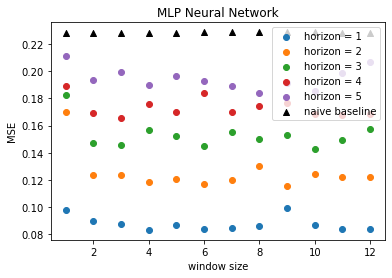

In [40]:
# Analysing MLP MSE for different Horizons while varying Window Size

import matplotlib.pyplot as plt
plt.figure()
for i in range(len(forecasting_horizons)):
    plt.scatter(window_sizes, MLP_master_model[i],label='horizon = {0}'.format(i+1))
    
plt.scatter(window_sizes, master_base[i],color='k',marker='^',label='naive baseline')
plt.xlabel('window size')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title('MLP Neural Network')
    

Text(0.5, 1.0, 'Random Forest')

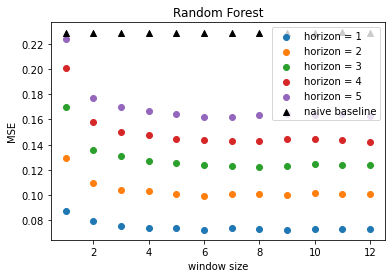

In [41]:
# Analysing Random Forest MSE for different Horizons while varying Window Size

import matplotlib.pyplot as plt
plt.figure()
for i in range(len(forecasting_horizons)):
    plt.scatter(window_sizes, RF_master_model[i],label='horizon = {0}'.format(i+1))
    
plt.scatter(window_sizes, master_base[0],color='k',marker='^',label='naive baseline')
plt.xlabel('window size')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title('Random Forest')
    

Text(0.5, 1.0, 'Gradient Boost')

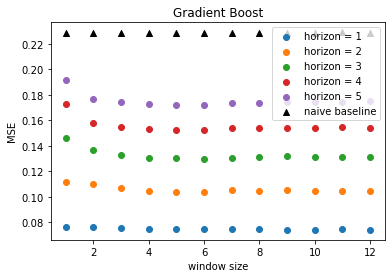

In [42]:
# Analysing Gradient Boost MSE for different Horizons while varying Window Size

import matplotlib.pyplot as plt
plt.figure()
for i in range(len(forecasting_horizons)):
    plt.scatter(window_sizes, GBoost_master_model[i],label='horizon = {0}'.format(i+1))

plt.scatter(window_sizes, master_base[0],color='k',marker='^',label='naive baseline')
plt.xlabel('window size')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title('Gradient Boost')
    

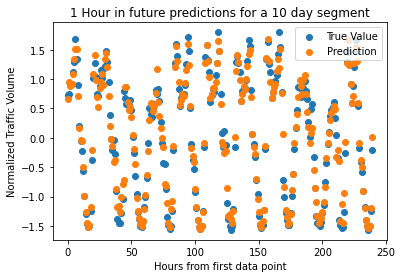

In [43]:
# Visualizing the preidction of the 1st hour using the Random Forest model during the 5 hour horizon testing

plt.figure()
i = 0
plt.title('1 Hour in future predictions for a 10 day segment')
plt.scatter(np.arange(len(RF_true[0][:240,i])),RF_true[0][:240,i],label='True Value')
plt.scatter(np.arange(len(RF_model_preds[0][:240,i])),RF_model_preds[0][:240,i], label=('Prediction'))
plt.xlabel('Hours from first data point')
plt.ylabel('Normalized Traffic Volume')
plt.legend()

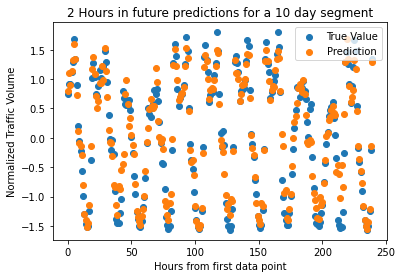

In [44]:
# Visualizing the preidction of the 2nd hour using the Random Forest model during the 5 hour horizon testing

plt.figure()
i = 1
plt.title('2 Hours in future predictions for a 10 day segment')
plt.scatter(np.arange(len(RF_true[0][:240,i])),RF_true[0][:240,i],label='True Value')
plt.scatter(np.arange(len(RF_model_preds[0][:240,i])),RF_model_preds[0][:240,i], label=('Prediction'))
plt.xlabel('Hours from first data point')
plt.ylabel('Normalized Traffic Volume')
plt.legend()

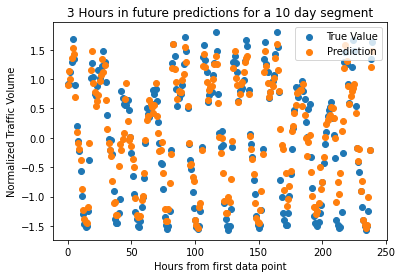

In [45]:
# Visualizing the preidction of the 3rd hour using the Random Forest model during the 5 hour horizon testing

plt.figure()
i = 2
plt.title('3 Hours in future predictions for a 10 day segment')
plt.scatter(np.arange(len(RF_true[0][:240,i])),RF_true[0][:240,i],label='True Value')
plt.scatter(np.arange(len(RF_model_preds[0][:240,i])),RF_model_preds[0][:240,i], label=('Prediction'))
plt.xlabel('Hours from first data point')
plt.ylabel('Normalized Traffic Volume')
plt.legend()

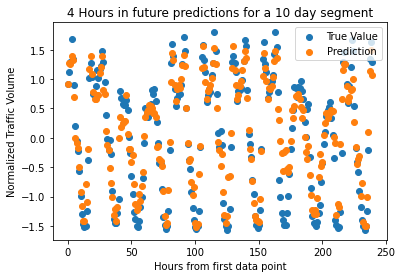

In [46]:
# Visualizing the preidction of the 4th hour using the Random Forest model during the 5 hour horizon testing

plt.figure()
i = 3
plt.title('4 Hours in future predictions for a 10 day segment')
plt.scatter(np.arange(len(RF_true[0][:240,i])),RF_true[0][:240,i],label='True Value')
plt.scatter(np.arange(len(RF_model_preds[0][:240,i])),RF_model_preds[0][:240,i], label=('Prediction'))
plt.xlabel('Hours from first data point')
plt.ylabel('Normalized Traffic Volume')
plt.legend()

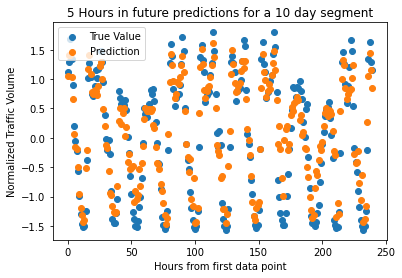

In [47]:
# Visualizing the preidction of the 5th hour using the Random Forest model during the 5 hour horizon testing

plt.figure()
i = 4
plt.title('5 Hours in future predictions for a 10 day segment')
plt.scatter(np.arange(len(RF_true[0][:240,i])),RF_true[0][:240,i],label='True Value')
plt.scatter(np.arange(len(RF_model_preds[0][:240,i])),RF_model_preds[0][:240,i], label=('Prediction'))
plt.xlabel('Hours from first data point')
plt.ylabel('Normalized Traffic Volume')
plt.legend()

In [48]:
# Building a summary table

# Initializing data storage lists
master_dat = []
MLP_dat = []
RF_dat = []
GBoost_dat = []

# Looping over a few horizons in this case h=1, h=3, h=5

for i in np.array([0,2,4]):
    
    # Finding the window size with minimum MSE at each horizon for each model
    opt_window_idx = np.argmin(MLP_master_model[i])
    MLP_dat.append(window_sizes[opt_window_idx])
    MLP_dat.append(MLP_master_model[i][opt_window_idx])
    
    opt_window_idx = np.argmin(RF_master_model[i])
    RF_dat.append(window_sizes[opt_window_idx])
    RF_dat.append(RF_master_model[i][opt_window_idx])

    
    opt_window_idx = np.argmin(GBoost_master_model[i])
    GBoost_dat.append(window_sizes[opt_window_idx])
    GBoost_dat.append(GBoost_master_model[i][opt_window_idx])

MLP_dat = np.array(MLP_dat)
RF_dat = np.array(RF_dat)
GBoost_dat = np.array(GBoost_dat)

master_dat = np.array([MLP_dat,RF_dat,GBoost_dat])

# Generating the table
columns = np.array(['n(h=1)','MSE[n(h=1)]',
                    'n(h=3)','MSE[n(h=3)]',
                    'n(h=5)','MSE[n(h=5)]',])
indices = np.array(['MLP','Random Forest','Gradient Boost'])
summary = pd.DataFrame(master_dat,index=indices,columns=columns)
pd.set_option("display.colheader_justify","right")


In [49]:
summary

,n(h=1),MSE[n(h=1)],n(h=3),MSE[n(h=3)],n(h=5),MSE[n(h=5)]
MLP,4.0,0.083337,10.0,0.142907,8.0,0.184026
Random Forest,9.0,0.072535,8.0,0.122565,7.0,0.162149
Gradient Boost,12.0,0.074070,6.0,0.130044,5.0,0.171731


**Note:** $n$ in the above table refers to the optimal window size for the given horizon.

#### d) Final questions

Answer the following questions briefly:

<ul>
  <li>Explain why the window size impacts the forecasting results.</li>
  <li>How does the forecasting accuracy change for different values of the forecasting horizon? Why does it change? Does it depend on the window size?</li>
  <li>For each model that you chose to evaluate, explain why you think they performed as they did.</li>
</ul>

**Answers here.**

**1)** 
\
When you increase the window size you are simply giving the model more information to base it's forecast off of. For example, if in the last hour it has snowed 0.5cm, this information may not be representative of the current situation, not a lot of snow has fallen so the model may expect traffic to be unaffected. However if we know that over the last 5 hours it has snowed 20cm we will expect an effect on traffic flow. Increasing the window size is synonymous to giving the model this additional information.

**2)** 
\
When you increase the forecasting horizon our MSE will naturally increase. This is because we are trying to predict further into the future, i.e. more data points, with the same amount of data points available to the model. The accuracy will depend on the window size, the more data you are using to make your prediction the easier it is for the model to capture a trend. Eventually the behaviour will converge and more data points will not increase the accuracy of the forecast, i.e. the model will not find the data from very far back relevant to the current forecast. 

**3)**
\
*MLP:* I am most surprised at the performance of MLP as I thought it was going to perform better than Random Forest / Gradient Boost. I chose to use 'adam' as the solver, which is a stochastic gradient-based optimizer. It is possible that in contrast to the Gradient Boost model that MLP underperformed in comparison as a result of our choice of metric. A disadvantage of neural networks that I am aware of is the need for large amounts of data, it is possible that data set size could have played a role. Alternatively we could have overfitting occuring for larger window sizes, as Neural Networks given large amounts of data can capture many "features" that other models may average out.
\
\
*Random Forest:* Random Forests are a good model choice to prevent overfitting of the data because of their averaging nature. I believe the more conservative nature of it's averaging behaviour led to consistently good results for different window sizes. 
\
\
*Gradient Boost:* Gradient Boost works by optimizing loss function, where the negative gradient is used to improve the model in each step. The default loss function is squared error, and given that I used MSE as my metric I imagine this is a major factor when looking at the stability and quality of the result.



## Task 2: Scientific paper presentation

In this task, you read the following paper and prepare a presentation for 10 minutes. You will give the presentation during the interview.

Title: "BatchBALD: Efficient and Diverse Batch Acquisition for Deep Bayesian Active Learning" 

Links:
https://proceedings.neurips.cc/paper/2019/hash/95323660ed2124450caaac2c46b5ed90-Abstract.html
and 
https://papers.nips.cc/paper/2019/file/95323660ed2124450caaac2c46b5ed90-Paper.pdf

## (Optional) Task 3: Active learning task 

This task is **optional**. The goal is to perform some simpel Active Learning study. You can use the following reference for this task. 

[1] https://burrsettles.com/pub/settles.activelearning.pdf

Begin by reading chapters 1-3 of [1] to get familiar with active learning (AL). Feel free to read other chapters or material about active learning. In this task we will deal with the pool-based setting of AL.

Let $\mathcal{X} \subseteq \mathbb{R}^d$ be the $d$-dimensional feature space and $\mathcal{Y}$ the label space. The structure of $\mathcal{Y}$ depends on the task (e.g., binary classification, multi-class classification or regression). We assume a model $f_{\theta}$ that is going to be trained (by active learning) to estimate/predict the labels. 

You are expected to experiment with active learning on two different **classification** datasets of your choice. It could be any dataset, e.g., from https://archive.ics.uci.edu/ml/index.php or synthetic/toy datasets from https://scikit-learn.org/stable/datasets/sample_generators.html. Given a dataset you may perform AL experiments according to the procedure outlined below:

<ol>
    <li>Treat the full dataset as the unlabeled dataset. You of course have the labels, which means that you can query the labels whenever needed or evaluate the entire pipeline using them (on test data).</li> 
    <li>Split the dataset into a training set $\mathcal{U}$ (which you perform the AL selection procedure on as described in the following steps) and a test set $\mathcal{V}$ which you use to evaluate $f_{\theta}$ in each iteration. This allows you to create AL plots such as Figure 3 in [1].</li>
    <li>Select an initial labeled dataset $\mathcal{L} \subset \mathcal{U}$ with random sampling.</li>
    <li>Train $f_{\theta}$ on $\mathcal{L}$ from scratch. Evaluate $f_{\theta}$ on $\mathcal{V}$ and save the result.</li>
    <li>Select some unqueried/unlabeled data $\mathcal{B}$ from $\mathcal{U}$ based on some AL selection strategy (see below), query (check the labels) of $\mathcal{B}$, and set $\mathcal{L} = \mathcal{L} \cup \mathcal{B}$.
    <li> Repeat from step 4 until $|\mathcal{L}|$ reaches some desired/meaningful value. 
</ol>


You may use any library you can find for implementing the AL selection strategies. I would recommend either AliPy (http://parnec.nuaa.edu.cn/huangsj/alipy/) or modAL (https://modal-python.readthedocs.io/en/latest/index.html) or a combination of them since they implement different selection strategies. For each of the two datasets, you should run **random sampling** as this is a common baseline selection strategy as well as at least **two** additional selection strategies. For each experiment there are a number of parameters to set such as the size of the batches $\mathcal{B}$, the architecture of $f_{\theta}$, parameters specific to a particular selection strategy, the size of the initial labeled dataset and possibly more. You are free to experiment with these parameters as you prefer **but remember to explain your observations when modifying the parameters**. 

Try to find two datasets in such a way the best performing AL selection strategies are **different** on them. If possible, try to explain why they are different in this case. Note that random sampling is a strong baseline and may perform really well in some cases, if it is the best strategy for some dataset, try to explain why you think this happens. 

**Answers in cells below this.**



**Bean Dataset**

In [56]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, entropy_sampling
from modAL.density import information_density
from modAL.batch import uncertainty_batch_sampling
from sklearn.ensemble import RandomForestClassifier
from IPython import display
from sklearn.model_selection import train_test_split

X = pd.read_excel('Dry_Bean_Dataset.xlsx')


In [57]:
###  Random Sampling

X_train, X_test = train_test_split(X, test_size=0.2, shuffle=True)

y_train = np.array(X_train.Class)
y_test = np.array(X_test.Class)
X_train = np.array(X_train.drop('Class',axis=1))
X_test = np.array(X_test.drop('Class',axis=1))


num_init = 100
#init_idx = np.random.choice(range(len(X_train)), size=num_init, replace=False) # False so that all samples are unique
init_idx = np.arange(0,num_init)

X_train_init , y_train_init = X_train[init_idx] , y_train[init_idx]
X_non_init , y_non_init = np.delete(X_train, init_idx, axis=0), np.delete(y_train, init_idx, axis=0)

model = ActiveLearner(estimator=RandomForestClassifier(),
                      X_training=X_train_init, y_training=y_train_init)

num_queries = 256
random_scores = [model.score(X_test,y_test)]


for i in range(num_queries):
    idx = np.random.choice(np.arange(0,len(X_non_init)))
    rand_inst = X_non_init[idx].reshape(1,-1)
    y_new = np.array([y_non_init[idx]],dtype='object')
    model.teach(rand_inst.reshape(1,-1), y_new)
    X_non_init, y_non_init = np.delete(X_non_init, idx, axis=0), np.delete(y_non_init, idx, axis=0)
    random_scores.append(model.score(X_test, y_test))




In [58]:
###  Testing using Uncertainty Sampling
'''
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=True)

y_train = np.array(X_train.Class)
y_test = np.array(X_test.Class)
X_train = np.array(X_train.drop('Class',axis=1))
X_test = np.array(X_test.drop('Class',axis=1))
'''

num_init = 100
#init_idx = np.random.choice(range(len(X_train)), size=num_init, replace=False) # False so that all samples are unique
init_idx = np.arange(0,num_init)

X_train_init , y_train_init = X_train[init_idx] , y_train[init_idx]
X_non_init , y_non_init = np.delete(X_train, init_idx, axis=0), np.delete(y_train, init_idx, axis=0)

model = ActiveLearner(estimator=RandomForestClassifier(),
                      query_strategy=uncertainty_sampling,
                      X_training=X_train_init, y_training=y_train_init)

num_queries = 256
uncertainty_scores = [model.score(X_test,y_test)]


for i in range(num_queries):
    query_idx, query_inst = model.query(X_non_init)
    y_new = y_non_init[query_idx]
    model.teach(query_inst.reshape(1,-1), y_new)
    X_non_init, y_non_init = np.delete(X_non_init, query_idx, axis=0), np.delete(y_non_init, query_idx, axis=0)
    uncertainty_scores.append(model.score(X_test, y_test))
    


In [59]:
###  Testing using Entropy Sampling
'''
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=True)

y_train = np.array(X_train.Class)
y_test = np.array(X_test.Class)
X_train = np.array(X_train.drop('Class',axis=1))
X_test = np.array(X_test.drop('Class',axis=1))
'''

num_init = 100
#init_idx = np.random.choice(range(len(X_train)), size=num_init, replace=False) # False so that all samples are unique
init_idx = np.arange(0,num_init)

X_train_init , y_train_init = X_train[init_idx] , y_train[init_idx]
X_non_init , y_non_init = np.delete(X_train, init_idx, axis=0), np.delete(y_train, init_idx, axis=0)

model = ActiveLearner(estimator=RandomForestClassifier(),
                      query_strategy=entropy_sampling,
                      X_training=X_train_init, y_training=y_train_init)

num_queries = 256
entropy_scores = [model.score(X_test,y_test)]


for i in range(num_queries):
    query_idx, query_inst = model.query(X_non_init)
    y_new = y_non_init[query_idx]
    model.teach(query_inst.reshape(1,-1), y_new)
    X_non_init, y_non_init = np.delete(X_non_init, query_idx, axis=0), np.delete(y_non_init, query_idx, axis=0)
    entropy_scores.append(model.score(X_test, y_test))
    

In [60]:
###  Using Max Information Density
'''
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=True)

y_train = np.array(X_train.Class)
y_test = np.array(X_test.Class)
X_train = np.array(X_train.drop('Class',axis=1))
X_test = np.array(X_test.drop('Class',axis=1))
'''

num_init = 100
#init_idx = np.random.choice(range(len(X_train)), size=num_init, replace=False) # False so that all samples are unique
init_idx = np.arange(0,num_init)

X_train_init , y_train_init = X_train[init_idx] , y_train[init_idx]
X_non_init , y_non_init = np.delete(X_train, init_idx, axis=0), np.delete(y_train, init_idx, axis=0)

model = ActiveLearner(estimator=RandomForestClassifier(),
                      X_training=X_train_init, y_training=y_train_init)

num_queries = 256
density_scores = [model.score(X_test,y_test)]


for i in range(num_queries):
    idx = np.argmax(information_density(X_non_init,metric='cosine'))
    rand_inst = X_non_init[idx].reshape(1,-1)
    y_new = np.array([y_non_init[idx]],dtype='object')
    model.teach(rand_inst.reshape(1,-1), y_new)
    X_non_init, y_non_init = np.delete(X_non_init, idx, axis=0), np.delete(y_non_init, idx, axis=0)
    density_scores.append(model.score(X_test, y_test))




Text(0, 0.5, 'Model Score on Test Set')

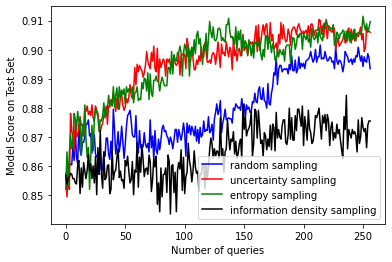

In [61]:
import matplotlib.pyplot as plt
plt.plot(np.arange(num_queries+1),random_scores,label='random sampling',color='b')
plt.plot(np.arange(num_queries+1),uncertainty_scores,label='uncertainty sampling',color='r')
plt.plot(np.arange(num_queries+1),entropy_scores,label='entropy sampling',color='g')
plt.plot(np.arange(num_queries+1),density_scores,label='information density sampling',color='k')

plt.legend()
plt.xlabel('Number of queries')
plt.ylabel('Model Score on Test Set')

**Explaining what I have studied above**

When I first began investigating the different sampling methods, I was using different training sets for each type of sampling method. I realised that this was the wrong way of approaching the problem, we want to see how the different sampling methods influence the learning process of our model. As a result I chose to use fixed training and test sets for each model that I trained, hence why all curves start from the same score. We can see for the case of the bean dataset that I have studied that entropy sampling and uncertainty sampling have comparable results, both outperforming random sampling after 256 queries. Entropy sampling appears to converge sooner than uncertainty sampling, and score slightly better at high queries. This leads to me conclude that entropy sampling performs slightly better than uncertainty sampling for this dataset. I talk more about reasoning after the second dataset analysis (bottom of notebook).

Not shown here is varying the initial training size. I initially started with a large training set, but soon realised that the point of these models is that we do not have a large training set available necessarily, and we want to train the model quickly and effectively. If we were to increase the training set we would simply have a much flatter learning curve as the model would have already reached a higher score. It would make the effects of random/uncertainty/entropy sampling seem negligible as we would be converging to the models optimal state.

I believe choosing the maximum information density feature sets fell behind in performance due to similarity in features that we learn from. In otherwords if we find that many dry beans in class "A" possess features sets that heavily inform us of class "A", we do no learn much about how to differentiate between Class "B" and "C". So even though we are "learning" a lot from the data we query, we are learning about something that we already know a lot about, whereas the other methods focus on feature sets that will help us understand how classes are different from eachother. Note that I tested the 'cosine' and 'euclidean' metrics for information density and received near identical results, I have thus chosen to only show one as this notebook is already getting long.

**Car Dataset**

In [23]:
X = pd.read_csv('car.data')

In [24]:
# Replacing strings with ints
prices = ['low','med','high','vhigh']
trunks = ['small','med','big']
safetys = ['low','med','high']
for i, price in enumerate(prices):
    X.buying_price = X.buying_price.replace(to_replace=price, value=i)
    X.maintenance_price = X.maintenance_price.replace(to_replace=price, value=i)
X.num_doors = X.num_doors.replace(to_replace='5more', value=5)
X.num_persons = X.num_persons.replace(to_replace='more', value=7)

for i, trunk in enumerate(trunks):
    X.trunk_size = X.trunk_size.replace(to_replace=trunk, value=i)
    
for i, safety in enumerate(safetys):
    X.safety = X.safety.replace(to_replace=safety, value=i)

In [25]:
###  Random Sampling

X_train, X_test = train_test_split(X, test_size=0.2, shuffle=True)

y_train = np.array(X_train.accuracy)
y_test = np.array(X_test.accuracy)
X_train = np.array(X_train.drop('accuracy',axis=1))
X_test = np.array(X_test.drop('accuracy',axis=1))


num_init = 20
#init_idx = np.random.choice(range(len(X_train)), size=num_init, replace=False) # False so that all samples are unique
init_idx = np.arange(0,num_init)

X_train_init , y_train_init = X_train[init_idx] , y_train[init_idx]
X_non_init , y_non_init = np.delete(X_train, init_idx, axis=0), np.delete(y_train, init_idx, axis=0)

model = ActiveLearner(estimator=RandomForestClassifier(),
                      X_training=X_train_init, y_training=y_train_init)

num_queries = 512
random_scores = [model.score(X_test,y_test)]


for i in range(num_queries):
    idx = np.random.choice(np.arange(0,len(X_non_init)))
    rand_inst = X_non_init[idx].reshape(1,-1)
    y_new = np.array([y_non_init[idx]],dtype='object')
    model.teach(rand_inst.reshape(1,-1), y_new)
    X_non_init, y_non_init = np.delete(X_non_init, idx, axis=0), np.delete(y_non_init, idx, axis=0)
    random_scores.append(model.score(X_test, y_test))




In [26]:
###  Testing using Uncertainty Sampling
'''
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=True)

y_train = np.array(X_train.Class)
y_test = np.array(X_test.Class)
X_train = np.array(X_train.drop('Class',axis=1))
X_test = np.array(X_test.drop('Class',axis=1))
'''

num_init = 20
#init_idx = np.random.choice(range(len(X_train)), size=num_init, replace=False) # False so that all samples are unique
init_idx = np.arange(0,num_init)

X_train_init , y_train_init = X_train[init_idx] , y_train[init_idx]
X_non_init , y_non_init = np.delete(X_train, init_idx, axis=0), np.delete(y_train, init_idx, axis=0)

model = ActiveLearner(estimator=RandomForestClassifier(),
                      query_strategy=uncertainty_sampling,
                      X_training=X_train_init, y_training=y_train_init)

num_queries = 512
uncertainty_scores = [model.score(X_test,y_test)]


for i in range(num_queries):
    query_idx, query_inst = model.query(X_non_init)
    y_new = y_non_init[query_idx]
    model.teach(query_inst.reshape(1,-1), y_new)
    X_non_init, y_non_init = np.delete(X_non_init, query_idx, axis=0), np.delete(y_non_init, query_idx, axis=0)
    uncertainty_scores.append(model.score(X_test, y_test))
    


In [27]:
###  Testing using Entropy Sampling
'''
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=True)

y_train = np.array(X_train.Class)
y_test = np.array(X_test.Class)
X_train = np.array(X_train.drop('Class',axis=1))
X_test = np.array(X_test.drop('Class',axis=1))
'''

num_init = 20
#init_idx = np.random.choice(range(len(X_train)), size=num_init, replace=False) # False so that all samples are unique
init_idx = np.arange(0,num_init)

X_train_init , y_train_init = X_train[init_idx] , y_train[init_idx]
X_non_init , y_non_init = np.delete(X_train, init_idx, axis=0), np.delete(y_train, init_idx, axis=0)

model = ActiveLearner(estimator=RandomForestClassifier(),
                      query_strategy=entropy_sampling,
                      X_training=X_train_init, y_training=y_train_init)

num_queries = 512
entropy_scores = [model.score(X_test,y_test)]


for i in range(num_queries):
    query_idx, query_inst = model.query(X_non_init)
    y_new = y_non_init[query_idx]
    model.teach(query_inst.reshape(1,-1), y_new)
    X_non_init, y_non_init = np.delete(X_non_init, query_idx, axis=0), np.delete(y_non_init, query_idx, axis=0)
    entropy_scores.append(model.score(X_test, y_test))
    

In [28]:
###  Using Max Information Density
'''
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=True)

y_train = np.array(X_train.Class)
y_test = np.array(X_test.Class)
X_train = np.array(X_train.drop('Class',axis=1))
X_test = np.array(X_test.drop('Class',axis=1))
'''

num_init = 20
#init_idx = np.random.choice(range(len(X_train)), size=num_init, replace=False) # False so that all samples are unique
init_idx = np.arange(0,num_init)

X_train_init , y_train_init = X_train[init_idx] , y_train[init_idx]
X_non_init , y_non_init = np.delete(X_train, init_idx, axis=0), np.delete(y_train, init_idx, axis=0)

model = ActiveLearner(estimator=RandomForestClassifier(),
                      X_training=X_train_init, y_training=y_train_init)

num_queries = 512
density_scores = [model.score(X_test,y_test)]


for i in range(num_queries):
    idx = np.argmax(information_density(X_non_init,metric='cosine'))
    rand_inst = X_non_init[idx].reshape(1,-1)
    y_new = np.array([y_non_init[idx]],dtype='object')
    model.teach(rand_inst.reshape(1,-1), y_new)
    X_non_init, y_non_init = np.delete(X_non_init, idx, axis=0), np.delete(y_non_init, idx, axis=0)
    density_scores.append(model.score(X_test, y_test))



In [29]:
###  Testing using Uncertainty Batch Sampling with B=20
'''
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=True)

y_train = np.array(X_train.Class)
y_test = np.array(X_test.Class)
X_train = np.array(X_train.drop('Class',axis=1))
X_test = np.array(X_test.drop('Class',axis=1))
'''

num_init = 20
#init_idx = np.random.choice(range(len(X_train)), size=num_init, replace=False) # False so that all samples are unique
init_idx = np.arange(0,num_init)

X_train_init , y_train_init = X_train[init_idx] , y_train[init_idx]
X_non_init , y_non_init = np.delete(X_train, init_idx, axis=0), np.delete(y_train, init_idx, axis=0)

model = ActiveLearner(estimator=RandomForestClassifier(),
                      query_strategy=uncertainty_batch_sampling,
                      X_training=X_train_init, y_training=y_train_init)

batch_size = 20
num_queries = 512//batch_size
batch20_scores = [model.score(X_test,y_test)]

for i in range(num_queries):
    query_idx, query_inst = model.query(X_non_init)
    for j in range(len(query_idx)):
        y_new = np.array([y_non_init[query_idx[j]]])
        model.teach(query_inst[j].reshape(1,-1), y_new)
    X_non_init, y_non_init = np.delete(X_non_init, query_idx, axis=0), np.delete(y_non_init, query_idx, axis=0)
    batch20_scores.append(model.score(X_test, y_test))


In [30]:
###  Testing using Uncertainty Batch Sampling with B=5
'''
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=True)

y_train = np.array(X_train.Class)
y_test = np.array(X_test.Class)
X_train = np.array(X_train.drop('Class',axis=1))
X_test = np.array(X_test.drop('Class',axis=1))
'''

num_init = 20
#init_idx = np.random.choice(range(len(X_train)), size=num_init, replace=False) # False so that all samples are unique
init_idx = np.arange(0,num_init)

X_train_init , y_train_init = X_train[init_idx] , y_train[init_idx]
X_non_init , y_non_init = np.delete(X_train, init_idx, axis=0), np.delete(y_train, init_idx, axis=0)

model = ActiveLearner(estimator=RandomForestClassifier(),
                      query_strategy=uncertainty_batch_sampling,
                      X_training=X_train_init, y_training=y_train_init)

batch_size = 5
num_queries = 512//batch_size
batch5_scores = [model.score(X_test,y_test)]

for i in range(num_queries):
    query_idx, query_inst = model.query(X_non_init,n_instances=batch_size)
    for j in range(len(query_idx)):
        y_new = np.array([y_non_init[query_idx[j]]])
        model.teach(query_inst[j].reshape(1,-1), y_new)
    X_non_init, y_non_init = np.delete(X_non_init, query_idx, axis=0), np.delete(y_non_init, query_idx, axis=0)
    batch5_scores.append(model.score(X_test, y_test))


In [31]:
###  Testing using Uncertainty Batch Sampling with B=10
'''
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=True)

y_train = np.array(X_train.Class)
y_test = np.array(X_test.Class)
X_train = np.array(X_train.drop('Class',axis=1))
X_test = np.array(X_test.drop('Class',axis=1))
'''

num_init = 20
#init_idx = np.random.choice(range(len(X_train)), size=num_init, replace=False) # False so that all samples are unique
init_idx = np.arange(0,num_init)

X_train_init , y_train_init = X_train[init_idx] , y_train[init_idx]
X_non_init , y_non_init = np.delete(X_train, init_idx, axis=0), np.delete(y_train, init_idx, axis=0)

model = ActiveLearner(estimator=RandomForestClassifier(),
                      query_strategy=uncertainty_batch_sampling,
                      X_training=X_train_init, y_training=y_train_init)

batch_size = 10
num_queries = 512//batch_size
batch10_scores = [model.score(X_test,y_test)]

for i in range(num_queries):
    query_idx, query_inst = model.query(X_non_init,n_instances=batch_size)
    for j in range(len(query_idx)):
        y_new = np.array([y_non_init[query_idx[j]]])
        model.teach(query_inst[j].reshape(1,-1), y_new)
    X_non_init, y_non_init = np.delete(X_non_init, query_idx, axis=0), np.delete(y_non_init, query_idx, axis=0)
    batch10_scores.append(model.score(X_test, y_test))

Text(0, 0.5, 'Model Score on Test Set')

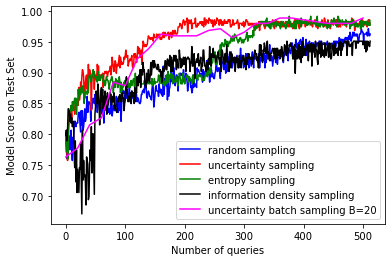

In [32]:
import matplotlib.pyplot as plt
plt.plot(np.arange(512+1),random_scores,label='random sampling',color='b')
plt.plot(np.arange(512+1),uncertainty_scores,label='uncertainty sampling',color='r')
plt.plot(np.arange(512+1),entropy_scores,label='entropy sampling',color='g')
plt.plot(np.arange(512+1),density_scores,label='information density sampling',color='k')
plt.plot(np.arange(0,512+1,20),batch20_scores,label='uncertainty batch sampling B=20',color='magenta')
#plt.plot(np.arange(0,512+1,10),batch10_scores,label='uncertainty batch sampling B=10',color='magenta',ls='dashed')
#plt.plot(np.arange(0,512+1,5),batch5_scores,label='uncertainty batch sampling B=5',color='magenta',ls='dashdot')

plt.legend()
plt.xlabel('Number of queries')
plt.ylabel('Model Score on Test Set')

**Explaining what I have studied above**

In this set of testing looking at the Car evaluation dataset we see that uncertainty sampling outperformed entropy sampling in terms of convergence rate, however both sampling methods scored similarly at high queries, unlike the dry bean dataset. The primary differences between the two data sets are the number of categories and the number of attributes (features). In the dry bean dataset we have 7 different classes and 16 features, whereas the car evaluation dataset has only 4 classes and 6 features. As a result it is understandable that uncertainty sampling will converge to a "optimal" model score sooner. I claim this because uncertainty sampling prioritizes feature sets where the choice between classes for the model are close, when there are less classes to select from we will naturally learn more from these cases in comparison to when we have many classes to choose from. I think this is most easily illustrated by example, if we have 4 classes, and we are unsure if it's class A or B, we will learn to differentiate between class A and B, which is differentiating between 2 of 4 classes. If there are 7 classes and the same scenario occurs we are learning much less about our entire data set in a relative sense. Entropy sampling compares all of the probabilities of prediction using the entropy formula, we should expect this in general to be more useful when we have many different classes to differentiate between. Information density continued to underperform similarly to the previous dataset that we investigated.

Text(0, 0.5, 'Model Score on Test Set')

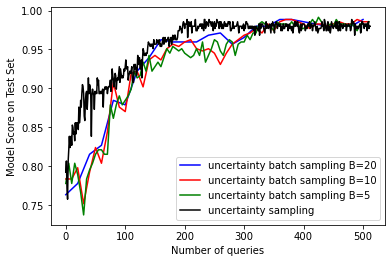

In [33]:
plt.plot(np.arange(0,512+1,20),batch20_scores,label='uncertainty batch sampling B=20',color='b')
plt.plot(np.arange(0,512+1,10),batch10_scores,label='uncertainty batch sampling B=10',color='r')
plt.plot(np.arange(0,512+1,5),batch5_scores,label='uncertainty batch sampling B=5',color='g')
plt.plot(np.arange(512+1),uncertainty_scores,label='uncertainty sampling',color='k')
plt.legend()
plt.xlabel('Number of queries')
plt.ylabel('Model Score on Test Set')

**Batch Sizes**

We can see that we don't lose much in terms of our learning curve when we use different batch sizes. It seems that just basic uncertainty sampling outperforms the rest, this is because after every iteration of teaching the model we reevaluate what feature set to use next. Whereas when a batch is selected the model learns from many feature sets when some of those features may be less useful after having learned from some other feature sets in the batch. This comes with a tradeoff, reevaluating the unlabeled set after every query is computationally expensive when the unlabeled set becomes large, as a result using batch sampling can be desirable, and does not come with a large tradeoff in accuracy.